<a href="https://colab.research.google.com/github/maimonahST/GP/blob/main/Stacking%2Bbagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import numpy as np

gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

# ICA

In [31]:
X = np.load('/content/drive/MyDrive/GP/GP-Data/X_ica2.npy')
y = np.load('/content/drive/MyDrive/GP/GP-Data/y_ica2.npy')
y = y.astype('int')

X.shape, y.shape

((45, 32, 32), (45,))

In [32]:
np.unique(y)

array([0, 1, 2])

In [52]:
# Load your dataset and split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


y_train[y_train==0] = 1 #Stroke
y_train[y_train==2] = 0 #Healthy

y_test[y_test==0] = 1 #Stroke
y_test[y_test==2] = 0 #Healthy


In [53]:
np.unique(y_train), np.unique(y_test)

(array([0, 1]), array([0, 1]))

In [55]:
# Scale the data using StandardScaler
scaler = StandardScaler3D()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)


## Ensemble

Ensemble ML models (Bernoulli NB, Adaboost, XGBoost, DT)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Stacking Accuracy on Train Set: 0.7777777777777778
Stacking Accuracy on Test Set: 0.7777777777777778
Stacking Precision on Test Set: 0.7777777777777778
Stacking Recall on Test Set: 0.7777777777777778
Stacking F1 Score on Test Set: 0.7777777777777778


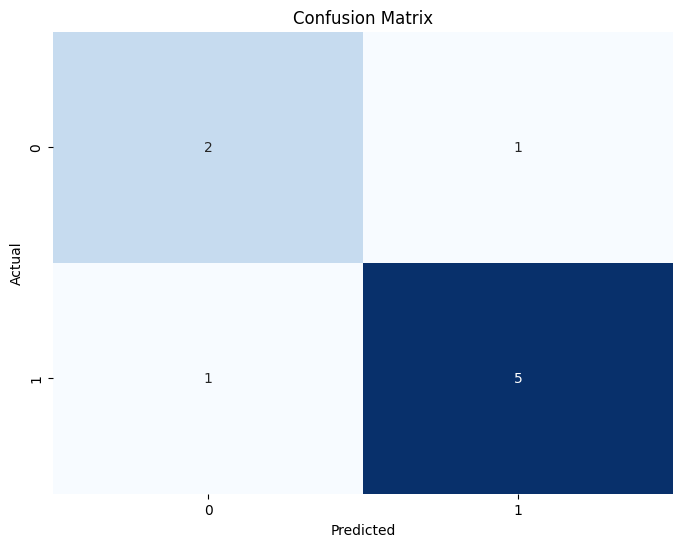

In [56]:
# Stacking (Stacked Generalization)
# Initialize base models
base_models = [
    ('bernoulli_nb', BernoulliNB(alpha=0.1, binarize = 0.0 , fit_prior = True)),
    ('adaboost', AdaBoostClassifier(n_estimators = 200, learning_rate = 1.0)),
    ('xgboost', XGBClassifier(max_depth = 9, n_estimators = 100, learning_rate = 0.01  )),
    ('decision_tree', DecisionTreeClassifier(criterion = 'gini', max_depth = 3, min_samples_leaf = 5))
]

# Initialize meta-model
meta_model = DecisionTreeClassifier()

# Initialize empty arrays to store predictions from base models
X_train_meta = np.zeros((len(X_train), len(base_models)))
X_test_meta = np.zeros((len(X_test), len(base_models)))

# Generate meta-features from base models using cross-validation
for i, (_, model) in enumerate(base_models):
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=5)
    y_pred_test = model.fit(X_train, y_train).predict(X_test)
    X_train_meta[:, i] = y_pred_train
    X_test_meta[:, i] = y_pred_test

# Train meta-model on meta-features
meta_model.fit(X_train_meta, y_train)

# Make predictions using meta-model
y_pred_meta_train = meta_model.predict(X_train_meta)
y_pred_meta_test = meta_model.predict(X_test_meta)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_meta_train)
accuracy_test = accuracy_score(y_test, y_pred_meta_test)
precision_test = precision_score(y_test, y_pred_meta_test, average='weighted')
recall_test = recall_score(y_test, y_pred_meta_test, average='weighted')
f1_score_test = f1_score(y_test, y_pred_meta_test, average='weighted')

print("Stacking Accuracy on Train Set:", accuracy_train)
print("Stacking Accuracy on Test Set:", accuracy_test)
print("Stacking Precision on Test Set:", precision_test)
print("Stacking Recall on Test Set:", recall_test)
print("Stacking F1 Score on Test Set:", f1_score_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_meta_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 16 members, which is less than n_splits=20.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/pyt

Stacking Accuracy on Train Set: 0.7222222222222222
Stacking Accuracy on Test Set: 0.7777777777777778
Stacking Precision on Test Set(weighted): 0.7777777777777778
Stacking Recall on Test Set(weighted): 0.7777777777777778
Stacking F1 Score on Test Set(weighted):0.7777777777777778 

Stacking Precision on Test Set(micro): 0.7777777777777778
Stacking Recall on Test Set(micro): 0.7777777777777778
Stacking F1 Score on Test Set(micro): 0.7777777777777778 

Stacking Precision on Test Set(macro): 0.75
Stacking Recall on Test Set(macro): 0.75
Stacking F1 Score on Test Set(macro): 0.75 



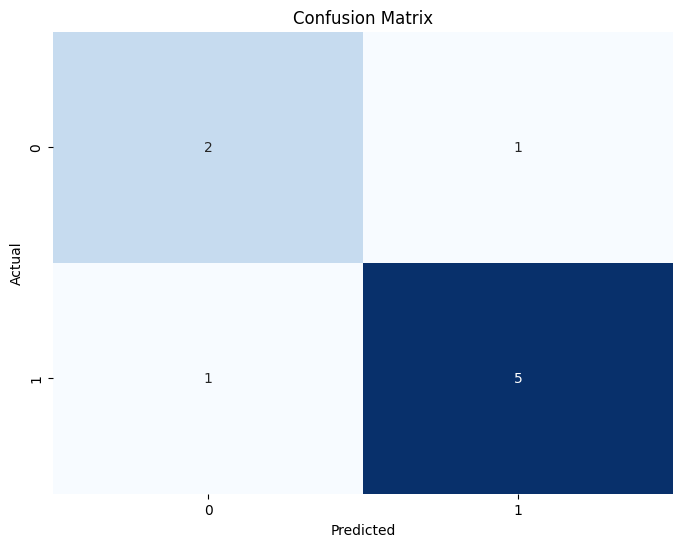

In [61]:
# Stacking (Stacked Generalization)
# Initialize base models
base_models = [
    ('bernoulli_nb', BernoulliNB(alpha=0.1, binarize = 0.0 , fit_prior = True)),
    ('adaboost', AdaBoostClassifier(n_estimators = 200, learning_rate = 1.0)),
    ('xgboost', XGBClassifier(max_depth = 9, n_estimators = 200, learning_rate = 0.01  )),
    ('decision_tree', DecisionTreeClassifier(criterion = 'gini', max_depth = 3, min_samples_leaf = 5))
]

# Initialize meta-model
meta_model = RandomForestClassifier(n_estimators=200, random_state=42)

# Initialize empty arrays to store predictions from base models
X_train_meta = np.zeros((len(X_train), len(base_models)))
X_test_meta = np.zeros((len(X_test), len(base_models)))

# Generate meta-features from base models using cross-validation
for i, (_, model) in enumerate(base_models):
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=20)
    y_pred_test = model.fit(X_train, y_train).predict(X_test)
    X_train_meta[:, i] = y_pred_train
    X_test_meta[:, i] = y_pred_test

# Train meta-model on meta-features
meta_model.fit(X_train_meta, y_train)

# Make predictions using meta-model
y_pred_meta_train = meta_model.predict(X_train_meta)
y_pred_meta_test = meta_model.predict(X_test_meta)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_meta_train)
accuracy_test = accuracy_score(y_test, y_pred_meta_test)
precision_test_W = precision_score(y_test, y_pred_meta_test, average='weighted')
recall_test_W = recall_score(y_test, y_pred_meta_test, average='weighted')
f1_score_test_W = f1_score(y_test, y_pred_meta_test, average='weighted')

precision_test_I = precision_score(y_test, y_pred_meta_test, average='micro')
recall_test_I = recall_score(y_test, y_pred_meta_test, average='micro')
f1_score_test_I = f1_score(y_test, y_pred_meta_test, average='micro')


precision_test_A = precision_score(y_test, y_pred_meta_test, average='macro')
recall_test_A = recall_score(y_test, y_pred_meta_test, average='macro')
f1_score_test_A = f1_score(y_test, y_pred_meta_test, average='macro')

print("Stacking Accuracy on Train Set:", accuracy_train)
print("Stacking Accuracy on Test Set:", accuracy_test)
print("Stacking Precision on Test Set(weighted):", precision_test_W)
print("Stacking Recall on Test Set(weighted):", recall_test_W)
print(f"Stacking F1 Score on Test Set(weighted):{f1_score_test_W} \n")


print("Stacking Precision on Test Set(micro):", precision_test_I)
print("Stacking Recall on Test Set(micro):", recall_test_I)
print(f"Stacking F1 Score on Test Set(micro): {f1_score_test_I} \n")

print("Stacking Precision on Test Set(macro):", precision_test_A)
print("Stacking Recall on Test Set(macro):", recall_test_A)
print(f"Stacking F1 Score on Test Set(macro): {f1_score_test_A} \n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_meta_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Stacking Accuracy on Train Set: 0.8055555555555556
Stacking Accuracy on Test Set: 0.7777777777777778
Stacking Precision on Test Set(weighted): 0.7777777777777778
Stacking Recall on Test Set(weighted): 0.7777777777777778
Stacking F1 Score on Test Set(weighted):0.7777777777777778 

Stacking Precision on Test Set(micro): 0.7777777777777778
Stacking Recall on Test Set(micro): 0.7777777777777778
Stacking F1 Score on Test Set(micro): 0.7777777777777778 

Stacking Precision on Test Set(macro): 0.75
Stacking Recall on Test Set(macro): 0.75
Stacking F1 Score on Test Set(macro): 0.75 



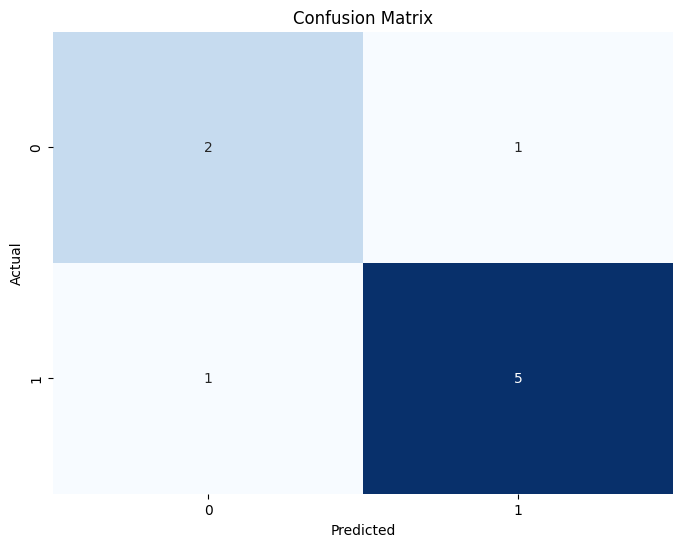

In [63]:
# Stacking (Stacked Generalization)
# Initialize base models
base_models = [
    ('bernoulli_nb', BernoulliNB(alpha=0.1, binarize = 0.0 , fit_prior = True)),
    ('adaboost', AdaBoostClassifier(n_estimators = 200, learning_rate = 1.0)),
    ('xgboost', XGBClassifier(max_depth = 9, n_estimators = 200, learning_rate = 0.01  )),
    ('decision_tree', DecisionTreeClassifier(criterion = 'gini', max_depth = 3, min_samples_leaf = 5))
]

# Initialize meta-model
meta_model = DecisionTreeClassifier()

# Initialize empty arrays to store predictions from base models
X_train_meta = np.zeros((len(X_train), len(base_models)))
X_test_meta = np.zeros((len(X_test), len(base_models)))

# Generate meta-features from base models using cross-validation
for i, (_, model) in enumerate(base_models):
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=10)
    y_pred_test = model.fit(X_train, y_train).predict(X_test)
    X_train_meta[:, i] = y_pred_train
    X_test_meta[:, i] = y_pred_test

# Train meta-model on meta-features
meta_model.fit(X_train_meta, y_train)

# Make predictions using meta-model
y_pred_meta_train = meta_model.predict(X_train_meta)
y_pred_meta_test = meta_model.predict(X_test_meta)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_meta_train)
accuracy_test = accuracy_score(y_test, y_pred_meta_test)
precision_test_W = precision_score(y_test, y_pred_meta_test, average='weighted')
recall_test_W = recall_score(y_test, y_pred_meta_test, average='weighted')
f1_score_test_W = f1_score(y_test, y_pred_meta_test, average='weighted')

precision_test_I = precision_score(y_test, y_pred_meta_test, average='micro')
recall_test_I = recall_score(y_test, y_pred_meta_test, average='micro')
f1_score_test_I = f1_score(y_test, y_pred_meta_test, average='micro')


precision_test_A = precision_score(y_test, y_pred_meta_test, average='macro')
recall_test_A = recall_score(y_test, y_pred_meta_test, average='macro')
f1_score_test_A = f1_score(y_test, y_pred_meta_test, average='macro')

print("Stacking Accuracy on Train Set:", accuracy_train)
print("Stacking Accuracy on Test Set:", accuracy_test)
print("Stacking Precision on Test Set(weighted):", precision_test_W)
print("Stacking Recall on Test Set(weighted):", recall_test_W)
print(f"Stacking F1 Score on Test Set(weighted):{f1_score_test_W} \n")


print("Stacking Precision on Test Set(micro):", precision_test_I)
print("Stacking Recall on Test Set(micro):", recall_test_I)
print(f"Stacking F1 Score on Test Set(micro): {f1_score_test_I} \n")

print("Stacking Precision on Test Set(macro):", precision_test_A)
print("Stacking Recall on Test Set(macro):", recall_test_A)
print(f"Stacking F1 Score on Test Set(macro): {f1_score_test_A} \n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_meta_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Epochs

In [3]:
def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


In [4]:
data_array = np.load('/content/drive/MyDrive/GP/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP/GP-Data/group_array.npy')

label_array = label_array.astype('int')

data_array.shape, label_array.shape, group_array.shape

((7150, 1250, 33), (7150,), (7150,))

In [5]:
np.unique(label_array)

array([0, 1, 2])

In [5]:
# Load your dataset and split into training and testing sets
X_train, X_test, y_train, y_test = two_splits(data_array, label_array, group_array)


y_train[y_train==0] = 1 #Stroke
y_train[y_train==2] = 0 #Healthy

y_test[y_test==0] = 1 #Stroke
y_test[y_test==2] = 0 #Healthy


group=[ 0  1  2  3  4  6  7  8 10 11 13 15 16 17 18 19 20 22 23 24 25 26 27 28
 29 30 31 32 33 34 36 37 39 41 42 43 44 46 47]
group=[ 5  9 12 14 21 35 38 40 45]


In [66]:
np.unique(y_train), np.unique(y_test)

(array([0, 1]), array([0, 1]))

In [6]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
# y_train = y_train.reshape(y_train.shape[0], -1)
# y_test = y_test.reshape(y_test.shape[0], -1)

In [8]:
# Stacking (Stacked Generalization)
# Initialize base models
base_models = [
    ('bernoulli_nb', BernoulliNB(alpha=0.1, binarize = 0.0 , fit_prior = True)),
    ('adaboost', AdaBoostClassifier(n_estimators = 200, learning_rate = 1.0)),
    ('xgboost', XGBClassifier(max_depth = 9, n_estimators = 200, learning_rate = 0.01  )),
    ('decision_tree', DecisionTreeClassifier(criterion = 'gini', max_depth = 3, min_samples_leaf = 5))
]

# Initialize meta-model
meta_model = DecisionTreeClassifier()

# Initialize empty arrays to store predictions from base models
X_train_meta = np.zeros((len(X_train), len(base_models)))
X_test_meta = np.zeros((len(X_test), len(base_models)))

# Generate meta-features from base models using cross-validation
for i, (_, model) in enumerate(base_models):
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=10)
    y_pred_test = model.fit(X_train, y_train).predict(X_test)
    X_train_meta[:, i] = y_pred_train
    X_test_meta[:, i] = y_pred_test

# Train meta-model on meta-features
meta_model.fit(X_train_meta, y_train)

# Make predictions using meta-model
y_pred_meta_train = meta_model.predict(X_train_meta)
y_pred_meta_test = meta_model.predict(X_test_meta)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_meta_train)
accuracy_test = accuracy_score(y_test, y_pred_meta_test)
precision_test_W = precision_score(y_test, y_pred_meta_test, average='weighted')
recall_test_W = recall_score(y_test, y_pred_meta_test, average='weighted')
f1_score_test_W = f1_score(y_test, y_pred_meta_test, average='weighted')

precision_test_I = precision_score(y_test, y_pred_meta_test, average='micro')
recall_test_I = recall_score(y_test, y_pred_meta_test, average='micro')
f1_score_test_I = f1_score(y_test, y_pred_meta_test, average='micro')


precision_test_A = precision_score(y_test, y_pred_meta_test, average='macro')
recall_test_A = recall_score(y_test, y_pred_meta_test, average='macro')
f1_score_test_A = f1_score(y_test, y_pred_meta_test, average='macro')

print("Stacking Accuracy on Train Set:", accuracy_train)
print("Stacking Accuracy on Test Set:", accuracy_test)
print("Stacking Precision on Test Set(weighted):", precision_test_W)
print("Stacking Recall on Test Set(weighted):", recall_test_W)
print(f"Stacking F1 Score on Test Set(weighted):{f1_score_test_W} \n")


print("Stacking Precision on Test Set(micro):", precision_test_I)
print("Stacking Recall on Test Set(micro):", recall_test_I)
print(f"Stacking F1 Score on Test Set(micro): {f1_score_test_I} \n")

print("Stacking Precision on Test Set(macro):", precision_test_A)
print("Stacking Recall on Test Set(macro):", recall_test_A)
print(f"Stacking F1 Score on Test Set(macro): {f1_score_test_A} \n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_meta_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Accuracy on Train Set: 1.0
Bagging Accuracy on Test Set: 0.40997830802603036
Bagging Precision on Test Set(weighted): 0.38788366867133406
Bagging Recall on Test Set(weighted): 0.40997830802603036
Bagging F1 Score on Test Set(weighted):0.39862506257300184 

Bagging Precision on Test Set(micro): 0.40997830802603036
Bagging Recall on Test Set(micro): 0.40997830802603036
Bagging F1 Score on Test Set(micro): 0.4099783080260304 

Bagging Precision on Test Set(macro): 0.28293413173652693
Bagging Recall on Test Set(macro): 0.2990506329113924
Bagging F1 Score on Test Set(macro): 0.2907692307692308 



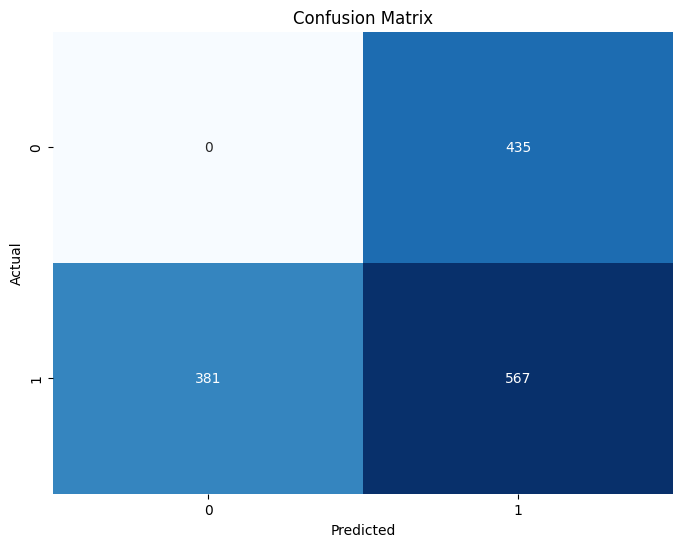

In [9]:
from sklearn.ensemble import BaggingClassifier

# Initialize base models
base_models = [
    ('bernoulli_nb', BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True)),
    ('adaboost', AdaBoostClassifier(n_estimators=100, learning_rate=1.0)),
    ('xgboost', XGBClassifier(max_depth=9, n_estimators=100, learning_rate=0.01)),
    ('decision_tree', DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5))
]

# Initialize meta-model
meta_model = DecisionTreeClassifier()

# Initialize empty arrays to store predictions from base models
X_train_meta = np.zeros((len(X_train), len(base_models)))
X_test_meta = np.zeros((len(X_test), len(base_models)))

# Generate meta-features from base models using bagging
for i, (_, model) in enumerate(base_models):
    bagging_model = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)
    y_pred_train = bagging_model.fit(X_train, y_train).predict(X_train)
    y_pred_test = bagging_model.predict(X_test)
    X_train_meta[:, i] = y_pred_train
    X_test_meta[:, i] = y_pred_test

# Train meta-model on meta-features
meta_model.fit(X_train_meta, y_train)

# Make predictions using meta-model
y_pred_meta_train = meta_model.predict(X_train_meta)
y_pred_meta_test = meta_model.predict(X_test_meta)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_meta_train)
accuracy_test = accuracy_score(y_test, y_pred_meta_test)
precision_test_W = precision_score(y_test, y_pred_meta_test, average='weighted')
recall_test_W = recall_score(y_test, y_pred_meta_test, average='weighted')
f1_score_test_W = f1_score(y_test, y_pred_meta_test, average='weighted')

precision_test_I = precision_score(y_test, y_pred_meta_test, average='micro')
recall_test_I = recall_score(y_test, y_pred_meta_test, average='micro')
f1_score_test_I = f1_score(y_test, y_pred_meta_test, average='micro')

precision_test_A = precision_score(y_test, y_pred_meta_test, average='macro')
recall_test_A = recall_score(y_test, y_pred_meta_test, average='macro')
f1_score_test_A = f1_score(y_test, y_pred_meta_test, average='macro')

print("Bagging Accuracy on Train Set:", accuracy_train)
print("Bagging Accuracy on Test Set:", accuracy_test)
print("Bagging Precision on Test Set(weighted):", precision_test_W)
print("Bagging Recall on Test Set(weighted):", recall_test_W)
print(f"Bagging F1 Score on Test Set(weighted):{f1_score_test_W} \n")

print("Bagging Precision on Test Set(micro):", precision_test_I)
print("Bagging Recall on Test Set(micro):", recall_test_I)
print(f"Bagging F1 Score on Test Set(micro): {f1_score_test_I} \n")

print("Bagging Precision on Test Set(macro):", precision_test_A)
print("Bagging Recall on Test Set(macro):", recall_test_A)
print(f"Bagging F1 Score on Test Set(macro): {f1_score_test_A} \n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_meta_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.ensemble import BaggingClassifier

# Initialize base models
base_models = [
    ('bernoulli_nb', BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True)),
    ('adaboost', AdaBoostClassifier(n_estimators=50, learning_rate=1.0)),
    ('xgboost', XGBClassifier(max_depth=9, n_estimators=100, learning_rate=0.01)),
    ('decision_tree', DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5))
]

# Initialize meta-model
meta_model = DecisionTreeClassifier()

# Initialize empty arrays to store predictions from base models
X_train_meta = np.zeros((len(X_train), len(base_models)))
X_test_meta = np.zeros((len(X_test), len(base_models)))

# Generate meta-features from base models using bagging
for i, (_, model) in enumerate(base_models):
    bagging_model = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)
    y_pred_train = bagging_model.fit(X_train, y_train).predict(X_train)
    y_pred_test = bagging_model.predict(X_test)
    X_train_meta[:, i] = y_pred_train
    X_test_meta[:, i] = y_pred_test

# Train meta-model on meta-features
meta_model.fit(X_train_meta, y_train)

# Make predictions using meta-model
y_pred_meta_train = meta_model.predict(X_train_meta)
y_pred_meta_test = meta_model.predict(X_test_meta)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_meta_train)
accuracy_test = accuracy_score(y_test, y_pred_meta_test)
precision_test_W = precision_score(y_test, y_pred_meta_test, average='weighted')
recall_test_W = recall_score(y_test, y_pred_meta_test, average='weighted')
f1_score_test_W = f1_score(y_test, y_pred_meta_test, average='weighted')

precision_test_I = precision_score(y_test, y_pred_meta_test, average='micro')
recall_test_I = recall_score(y_test, y_pred_meta_test, average='micro')
f1_score_test_I = f1_score(y_test, y_pred_meta_test, average='micro')

precision_test_A = precision_score(y_test, y_pred_meta_test, average='macro')
recall_test_A = recall_score(y_test, y_pred_meta_test, average='macro')
f1_score_test_A = f1_score(y_test, y_pred_meta_test, average='macro')

print("Bagging Accuracy on Train Set:", accuracy_train)
print("Bagging Accuracy on Test Set:", accuracy_test)
print("Bagging Precision on Test Set(weighted):", precision_test_W)
print("Bagging Recall on Test Set(weighted):", recall_test_W)
print(f"Bagging F1 Score on Test Set(weighted):{f1_score_test_W} \n")

print("Bagging Precision on Test Set(micro):", precision_test_I)
print("Bagging Recall on Test Set(micro):", recall_test_I)
print(f"Bagging F1 Score on Test Set(micro): {f1_score_test_I} \n")

print("Bagging Precision on Test Set(macro):", precision_test_A)
print("Bagging Recall on Test Set(macro):", recall_test_A)
print(f"Bagging F1 Score on Test Set(macro): {f1_score_test_A} \n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_meta_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


bernoulli_nb Mean Accuracy: 0.6249360796415349, Std: 0.003789002189786558
adaboost Mean Accuracy: 0.5141081738393251, Std: 0.1460023759714937
xgboost Mean Accuracy: 0.5460107834133247, Std: 0.09815093566328614
decision_tree Mean Accuracy: 0.5647469264867027, Std: 0.12223927336738474
Stacking Accuracy on Train Set: 1.0
Stacking Accuracy on Test Set: 0.47216196673897326
Stacking Precision on Test Set (weighted): 0.344825204230147
Stacking Recall on Test Set (weighted): 0.47216196673897326
Stacking F1 Score on Test Set (weighted): 0.38672955556085126


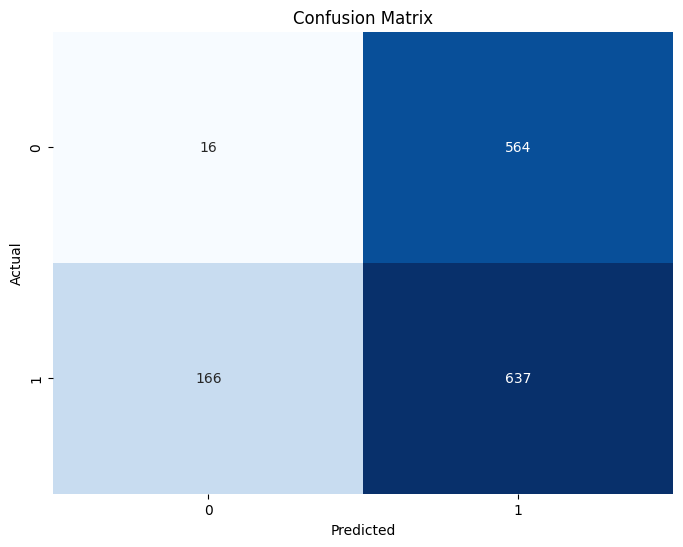

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Define base models with hyperparameters
base_models = {
    'bernoulli_nb': BernoulliNB(),
    'adaboost': AdaBoostClassifier(),
    'xgboost': XGBClassifier(),
    'decision_tree': DecisionTreeClassifier()
}

# Define meta-model with hyperparameters
meta_model = DecisionTreeClassifier()

# Initialize empty arrays to store predictions from base models
X_train_meta = np.zeros((len(X_train), len(base_models)))
X_test_meta = np.zeros((len(X_test), len(base_models)))

# Generate meta-features from base models using cross-validation
for i, (name, model) in enumerate(base_models.items()):
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Mean Accuracy: {scores.mean()}, Std: {scores.std()}")
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    X_train_meta[:, i] = y_pred_train
    X_test_meta[:, i] = y_pred_test

# Train meta-model on meta-features
meta_model.fit(X_train_meta, y_train)

# Make predictions using meta-model
y_pred_meta_train = meta_model.predict(X_train_meta)
y_pred_meta_test = meta_model.predict(X_test_meta)

# Calculate evaluation metrics
accuracy_train = accuracy_score(y_train, y_pred_meta_train)
accuracy_test = accuracy_score(y_test, y_pred_meta_test)
precision_test = precision_score(y_test, y_pred_meta_test, average='weighted')
recall_test = recall_score(y_test, y_pred_meta_test, average='weighted')
f1_score_test = f1_score(y_test, y_pred_meta_test, average='weighted')

print("Stacking Accuracy on Train Set:", accuracy_train)
print("Stacking Accuracy on Test Set:", accuracy_test)
print("Stacking Precision on Test Set (weighted):", precision_test)
print("Stacking Recall on Test Set (weighted):", recall_test)
print("Stacking F1 Score on Test Set (weighted):", f1_score_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_meta_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()